In [1]:
import torch
import torchaudio
import torchvision.transforms as transforms
from torchvision.models import vgg16, VGG16_Weights
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sys
sys.path.append("../")
from ad_utils import *
from torch.nn.utils import spectral_norm


cuda0 = torch.device("cuda:0")
cuda1 = torch.device("cuda:1")
device = cuda1
print(torch.cuda.get_device_name(device) if torch.cuda.is_available() else "No GPU available")

data = np.load("../../hvcm/RFQ.npy", allow_pickle=True)
label = np.load("../../hvcm/RFQ_labels.npy", allow_pickle=True)
label = label[:, 1]  # Assuming the second column is the label
label = (label == "Fault").astype(int)  # Convert to binary labels
print(data.shape, label.shape)

scaler = StandardScaler()
data = scaler.fit_transform(data.reshape(-1, data.shape[-1])).reshape(data.shape)

normal_data = data[label == 0]
faulty_data = data[label == 1]

normal_label = label[label == 0]
faulty_label = label[label == 1]

X_train_normal, X_test_normal, y_train_normal, y_test_normal = train_test_split(normal_data, normal_label, test_size=0.2, random_state=42, shuffle=True)
X_train_faulty, X_test_faulty, y_train_faulty, y_test_faulty = train_test_split(faulty_data, faulty_label, test_size=0.2, random_state=42, shuffle=True)

NVIDIA A30
(872, 4500, 14) (872,)


# Cycle GAN

In [2]:
# Improved Residual Block for Time Series
class TimeSeriesResidualBlock(nn.Module):
    def __init__(self, channels, kernel_size=5):  # Changed from 3 to 5 for better temporal patterns
        super().__init__()
        self.conv1 = nn.Conv1d(channels, channels, kernel_size, padding=kernel_size//2)
        self.norm1 = nn.BatchNorm1d(channels)
        self.conv2 = nn.Conv1d(channels, channels, kernel_size, padding=kernel_size//2)
        self.norm2 = nn.BatchNorm1d(channels)
        self.activation = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, x):
        residual = x
        out = self.activation(self.norm1(self.conv1(x)))
        out = self.dropout(out)
        out = self.norm2(self.conv2(out))
        return self.activation(out + residual)

# Enhanced Generator for Time Series
class TimeSeriesGenerator(nn.Module):
    def __init__(self, input_channels=14, hidden_dim=64, n_residual_blocks=4):  # Reduced complexity for long sequences
        super().__init__()
        
        # Initial convolution with larger kernel for temporal context
        self.initial = nn.Sequential(
            nn.Conv1d(input_channels, hidden_dim//2, kernel_size=7, padding=3),
            nn.BatchNorm1d(hidden_dim//2),
            nn.ReLU(inplace=True)
        )
        
        # Downsampling layers with stride=4 for long sequences
        self.down1 = nn.Sequential(
            nn.Conv1d(hidden_dim//2, hidden_dim, kernel_size=5, stride=4, padding=2),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True)
        )
        
        self.down2 = nn.Sequential(
            nn.Conv1d(hidden_dim, hidden_dim*2, kernel_size=5, stride=4, padding=2),
            nn.BatchNorm1d(hidden_dim*2),
            nn.ReLU(inplace=True)
        )
        
        # Residual blocks for feature refinement
        self.residual_blocks = nn.ModuleList([
            TimeSeriesResidualBlock(hidden_dim*2) for _ in range(n_residual_blocks)
        ])
        
        # Upsampling layers with stride=4 to match downsampling
        self.up1 = nn.Sequential(
            nn.ConvTranspose1d(hidden_dim*2, hidden_dim, kernel_size=5, stride=4, padding=2, output_padding=3),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True)
        )
        
        self.up2 = nn.Sequential(
            nn.ConvTranspose1d(hidden_dim, hidden_dim//2, kernel_size=5, stride=4, padding=2, output_padding=3),
            nn.BatchNorm1d(hidden_dim//2),
            nn.ReLU(inplace=True)
        )
        
        # Final output layer
        self.final = nn.Sequential(
            nn.Conv1d(hidden_dim//2, input_channels, kernel_size=7, padding=3),
            nn.Tanh()
        )
        
    def forward(self, x):
        original_size = x.size(2)
        x = self.initial(x)
        x = self.down1(x)
        x = self.down2(x)
        
        for block in self.residual_blocks:
            x = block(x)
            
        x = self.up1(x)
        x = self.up2(x)
        
        # Ensure exact sequence length restoration
        if x.size(2) != original_size:
            x = nn.functional.interpolate(x, size=original_size, mode='linear', align_corners=False)
        
        x = self.final(x)
        return x

# Enhanced Discriminator for Time Series
class TimeSeriesDiscriminator(nn.Module):
    def __init__(self, input_channels=14, hidden_dim=32):  # Reduced for memory efficiency
        super().__init__()
        
        self.model = nn.Sequential(
            # Progressive downsampling for long sequences
            spectral_norm(nn.Conv1d(input_channels, hidden_dim, kernel_size=5, stride=4, padding=2)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.25),
            
            spectral_norm(nn.Conv1d(hidden_dim, hidden_dim*2, kernel_size=5, stride=4, padding=2)),
            nn.BatchNorm1d(hidden_dim*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.25),
            
            spectral_norm(nn.Conv1d(hidden_dim*2, hidden_dim*4, kernel_size=5, stride=4, padding=2)),
            nn.BatchNorm1d(hidden_dim*4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.25),
            
            spectral_norm(nn.Conv1d(hidden_dim*4, hidden_dim*8, kernel_size=5, stride=4, padding=2)),
            nn.BatchNorm1d(hidden_dim*8),
            nn.LeakyReLU(0.2, inplace=True),
            
            spectral_norm(nn.Conv1d(hidden_dim*8, 1, kernel_size=5, padding=2)),
            nn.AdaptiveAvgPool1d(1)
        )
        
    def forward(self, x):
        return self.model(x).squeeze()

# Enhanced CycleGAN training function
def train_cyclegan_timeseries_stable(normal_data, device, epochs=200, batch_size=8, lr=2e-4):
    """
    Enhanced CycleGAN training optimized for multivariate time series
    """
    print(f"Training CycleGAN on data shape: {normal_data.shape}")
    
    # Better data preprocessing for time series
    data_mean = np.mean(normal_data, axis=(0, 1), keepdims=True)
    data_std = np.std(normal_data, axis=(0, 1), keepdims=True) + 1e-8
    
    # Normalize to [-1, 1] for Tanh output
    normalized_data = (normal_data - data_mean) / (3 * data_std)
    normalized_data = np.clip(normalized_data, -1, 1)
    
    # Split data into two temporal domains (first half vs second half)
    mid_point = len(normalized_data) // 2
    domain_A = normalized_data[:mid_point]
    domain_B = normalized_data[mid_point:]
    
    # Convert to tensors (batch, channels, seq_len)
    tensor_A = torch.tensor(domain_A, dtype=torch.float32).permute(0, 2, 1)
    tensor_B = torch.tensor(domain_B, dtype=torch.float32).permute(0, 2, 1)
    
    dataset = TensorDataset(tensor_A, tensor_B)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    
    # Initialize networks with optimized parameters
    G_AB = TimeSeriesGenerator().to(device)
    G_BA = TimeSeriesGenerator().to(device)
    D_A = TimeSeriesDiscriminator().to(device)
    D_B = TimeSeriesDiscriminator().to(device)
    
    # Balanced optimizers for time series
    optimizer_G = optim.Adam(
        list(G_AB.parameters()) + list(G_BA.parameters()),
        lr=lr, betas=(0.5, 0.999)
    )
    optimizer_D_A = optim.Adam(D_A.parameters(), lr=lr/2, betas=(0.5, 0.999))
    optimizer_D_B = optim.Adam(D_B.parameters(), lr=lr/2, betas=(0.5, 0.999))
        
    def adversarial_loss_smooth(pred, target_is_real):
        if target_is_real:
            target = torch.ones_like(pred) * (0.8 + 0.2 * torch.rand_like(pred))
        else:
            target = torch.zeros_like(pred) + 0.2 * torch.rand_like(pred)
        return nn.MSELoss()(pred, target)
    
    cycle_loss = nn.L1Loss()
    identity_loss = nn.L1Loss()
    
    # Training history
    history = {
        'G_loss': [], 'D_A_loss': [], 'D_B_loss': [],
        'cycle_loss': [], 'identity_loss': []
    }
    
    print("Starting optimized training for time series...")
    for epoch in range(epochs):
        epoch_G_loss = 0
        epoch_D_A_loss = 0
        epoch_D_B_loss = 0
        epoch_cycle_loss = 0
        epoch_identity_loss = 0
        
        for i, (real_A, real_B) in enumerate(dataloader):
            real_A, real_B = real_A.to(device), real_B.to(device)
            
            # Train discriminators less frequently for balance
            if i % 2 == 0:
                # ============ Train Discriminator A ============
                optimizer_D_A.zero_grad()
                
                fake_A = G_BA(real_B).detach()
                
                pred_real_A = D_A(real_A)
                pred_fake_A = D_A(fake_A)
                
                loss_D_real_A = adversarial_loss_smooth(pred_real_A, True)
                loss_D_fake_A = adversarial_loss_smooth(pred_fake_A, False)
                
                loss_D_A = (loss_D_real_A + loss_D_fake_A) * 0.5
                loss_D_A.backward()
                optimizer_D_A.step()
                
                # ============ Train Discriminator B ============
                optimizer_D_B.zero_grad()
                
                fake_B = G_AB(real_A).detach()
                
                pred_real_B = D_B(real_B)
                pred_fake_B = D_B(fake_B)
                
                loss_D_real_B = adversarial_loss_smooth(pred_real_B, True)
                loss_D_fake_B = adversarial_loss_smooth(pred_fake_B, False)
                
                loss_D_B = (loss_D_real_B + loss_D_fake_B) * 0.5
                loss_D_B.backward()
                optimizer_D_B.step()
            
            # ============ Train Generators ============
            optimizer_G.zero_grad()
            
            # Identity loss (reduced weight for time series)
            identity_B = G_AB(real_B)
            identity_A = G_BA(real_A)
            loss_identity = (identity_loss(identity_B, real_B) + 
                           identity_loss(identity_A, real_A)) * 1.0
            
            # GAN loss
            fake_B = G_AB(real_A)
            fake_A = G_BA(real_B)
            
            pred_fake_B = D_B(fake_B)
            pred_fake_A = D_A(fake_A)
            
            loss_GAN_AB = adversarial_loss_smooth(pred_fake_B, True)
            loss_GAN_BA = adversarial_loss_smooth(pred_fake_A, True)
            
            # Cycle consistency loss (higher weight for time series)
            recovered_A = G_BA(fake_B)
            recovered_B = G_AB(fake_A)
            loss_cycle = (cycle_loss(recovered_A, real_A) + 
                         cycle_loss(recovered_B, real_B)) * 15.0
            
            # Total generator loss
            loss_G = loss_GAN_AB + loss_GAN_BA + loss_cycle + loss_identity
            loss_G.backward()
            optimizer_G.step()
            
            # Accumulate losses
            epoch_G_loss += loss_G.item()
            epoch_D_A_loss += loss_D_A.item() if i % 2 == 0 else 0
            epoch_D_B_loss += loss_D_B.item() if i % 2 == 0 else 0
            epoch_cycle_loss += loss_cycle.item()
            epoch_identity_loss += loss_identity.item()
        
        # Average losses
        num_batches = len(dataloader)
        epoch_G_loss /= num_batches
        epoch_D_A_loss /= (num_batches // 2)
        epoch_D_B_loss /= (num_batches // 2)
        epoch_cycle_loss /= num_batches
        epoch_identity_loss /= num_batches
        
        # Store history
        history['G_loss'].append(epoch_G_loss)
        history['D_A_loss'].append(epoch_D_A_loss)
        history['D_B_loss'].append(epoch_D_B_loss)
        history['cycle_loss'].append(epoch_cycle_loss)
        history['identity_loss'].append(epoch_identity_loss)
        
        # Print progress every 10 epochs
        if epoch % 10 == 0 or epoch == epochs - 1:
            print(f"Epoch [{epoch+1}/{epochs}] - "
                  f"G: {epoch_G_loss:.4f}, D_A: {epoch_D_A_loss:.4f}, D_B: {epoch_D_B_loss:.4f}, "
                  f"Cycle: {epoch_cycle_loss:.4f}, Identity: {epoch_identity_loss:.4f}")

    # Store normalization parameters
    data_stats = (data_mean, data_std)
    return G_AB, G_BA, history, data_stats

# Generate synthetic data using CycleGAN
def generate_synthetic_data(generator, original_data, data_stats, device, num_samples=None):
    """
    Generate synthetic time series data using CycleGAN domain translation
    """
    if num_samples is None:
        num_samples = len(original_data)
    
    generator.eval()
    data_mean, data_std = data_stats
    
    # Normalize input data
    normalized_input = (original_data - data_mean) / (3 * data_std)
    normalized_input = np.clip(normalized_input, -1, 1)
    
    synthetic_samples = []
    
    with torch.no_grad():
        # Convert to tensor format (batch, channels, seq_len)
        tensor_data = torch.tensor(normalized_input[:num_samples], dtype=torch.float32).permute(0, 2, 1)
        
        # Generate in batches for memory efficiency
        batch_size = 16
        for i in range(0, len(tensor_data), batch_size):
            batch = tensor_data[i:i+batch_size].to(device)
            synthetic_batch = generator(batch)
            
            # Denormalize back to original scale
            synthetic_batch = synthetic_batch.cpu().permute(0, 2, 1).numpy()
            synthetic_batch = synthetic_batch * (3 * data_std) + data_mean
            
            synthetic_samples.append(synthetic_batch)
        
        # Concatenate all batches
        synthetic_data = np.concatenate(synthetic_samples, axis=0)
    
    return synthetic_data[:num_samples]

# Train, and generate

In [3]:

# Example usage
print("Starting CycleGAN training for time series data...")
G_AB, G_BA, history, data_stats = train_cyclegan_timeseries_stable(
    X_train_normal, 
    device, 
    epochs=200,  # Reduced for testing
    batch_size=32,  # Smaller batch size for your data
    lr=0.005  # Slightly lower learning rate
)

# Generate synthetic data using the returned data_stats
print("Generating synthetic data...")
synthetic_data = generate_synthetic_data(G_AB, X_train_normal, data_stats, device, num_samples=len(X_train_normal))

print(f"Original data shape: {normal_data.shape}")
print(f"Synthetic data shape: {synthetic_data.shape}")




Starting CycleGAN training for time series data...
Training CycleGAN on data shape: (552, 4500, 14)
Starting optimized training for time series...
Epoch [1/200] - G: 10.5128, D_A: 0.8313, D_B: 0.6222, Cycle: 8.0191, Identity: 0.5590
Epoch [11/200] - G: 6.8535, D_A: 0.1404, D_B: 0.0679, Cycle: 5.2497, Identity: 0.3936
Epoch [21/200] - G: 3.7977, D_A: 0.1530, D_B: 0.1136, Cycle: 2.7752, Identity: 0.1985
Epoch [31/200] - G: 2.5281, D_A: 0.1105, D_B: 0.1432, Cycle: 1.7921, Identity: 0.1402
Epoch [41/200] - G: 2.0616, D_A: 0.1497, D_B: 0.1965, Cycle: 1.5300, Identity: 0.1205
Epoch [51/200] - G: 1.8135, D_A: 0.1487, D_B: 0.1328, Cycle: 1.3003, Identity: 0.0927
Epoch [61/200] - G: 1.7974, D_A: 0.1641, D_B: 0.1345, Cycle: 1.2174, Identity: 0.0866
Epoch [71/200] - G: 1.6828, D_A: 0.1958, D_B: 0.1655, Cycle: 1.0991, Identity: 0.0771
Epoch [81/200] - G: 1.7011, D_A: 0.1946, D_B: 0.1398, Cycle: 1.0830, Identity: 0.0773
Epoch [91/200] - G: 1.7311, D_A: 0.1962, D_B: 0.1433, Cycle: 1.0827, Identity: 

In [4]:
# ===============================
# FID SCORE EVALUATION
# ===============================

# Test the simplified FID calculation
print("Testing simplified FID calculation...")

# Use smaller subsets for testing
test_real = X_train_normal[:100]  # Use 100 samples for testing
test_generated = synthetic_data[:100]

print(f"Test real data shape: {test_real.shape}")
print(f"Test generated data shape: {test_generated.shape}")

# Calculate FID score
fid_score = calculate_fid_score(
    real_data=test_real,
    fake_data=test_generated,
    device=device,
    sample_rate=1000,
)

if fid_score is not None:
    print(f"\n🎉 SUCCESS! FID Score: {fid_score:.4f}")
    
    # Interpret the score
    if fid_score < 10:
        quality = "Excellent"
    elif fid_score < 25:
        quality = "Good"
    elif fid_score < 50:
        quality = "Fair"
    elif fid_score < 100:
        quality = "Poor"
    else:
        quality = "Very Poor"
    
    print(f"Quality Assessment: {quality}")
else:
    print("❌ FID calculation failed. Please check the error messages above.")

Testing simplified FID calculation...
Test real data shape: (100, 4500, 14)
Test generated data shape: (100, 4500, 14)
Processing real data for FID...
Processing 100 samples for FID calculation (299x299)...
Processed 0/100 samples
Processing fake data for FID...
Processing 100 samples for FID calculation (299x299)...
Processed 0/100 samples
Calculating FID with 100 samples each...
Real images shape: torch.Size([100, 3, 299, 299])
Fake images shape: torch.Size([100, 3, 299, 299])
Real images range: [0.0000, 0.9816]
Fake images range: [0.0000, 0.9743]
After clamping - Real images range: [0.0000, 0.9816]
After clamping - Fake images range: [0.0000, 0.9743]
FID Score: 1.2045

🎉 SUCCESS! FID Score: 1.2045
Quality Assessment: Excellent



COMPREHENSIVE ANOMALY DETECTION CROSS-VALIDATION EXPERIMENT
Normal samples: 138
Faulty samples: 37
Generated samples: 552 (GAN Type: cycle)
Cross-validation folds: 5

========================= FOLD 1/5 =========================
Fold 1 - Train normal: 110
Fold 1 - Train faulty: 30
Fold 1 - Test: 35 (28 normal, 7 faulty)
Processing data through feature extraction...
Processing 30 samples with multi-channel approach...
Processing 35 samples with multi-channel approach...
Processing 110 samples with multi-channel approach...
Training baseline autoencoder (without GAN)...
Fold 1 - Augmented normal data: 662 samples
Processing 662 samples with multi-channel approach...
Training GAN-augmented autoencoder...

Fold 1 Results Comparison:
--------------------------------------------------------------------------------
Method             | Metric   | Baseline   | GAN-Aug    | Improvement 
--------------------------------------------------------------------------------
F1_Threshold       | accurac

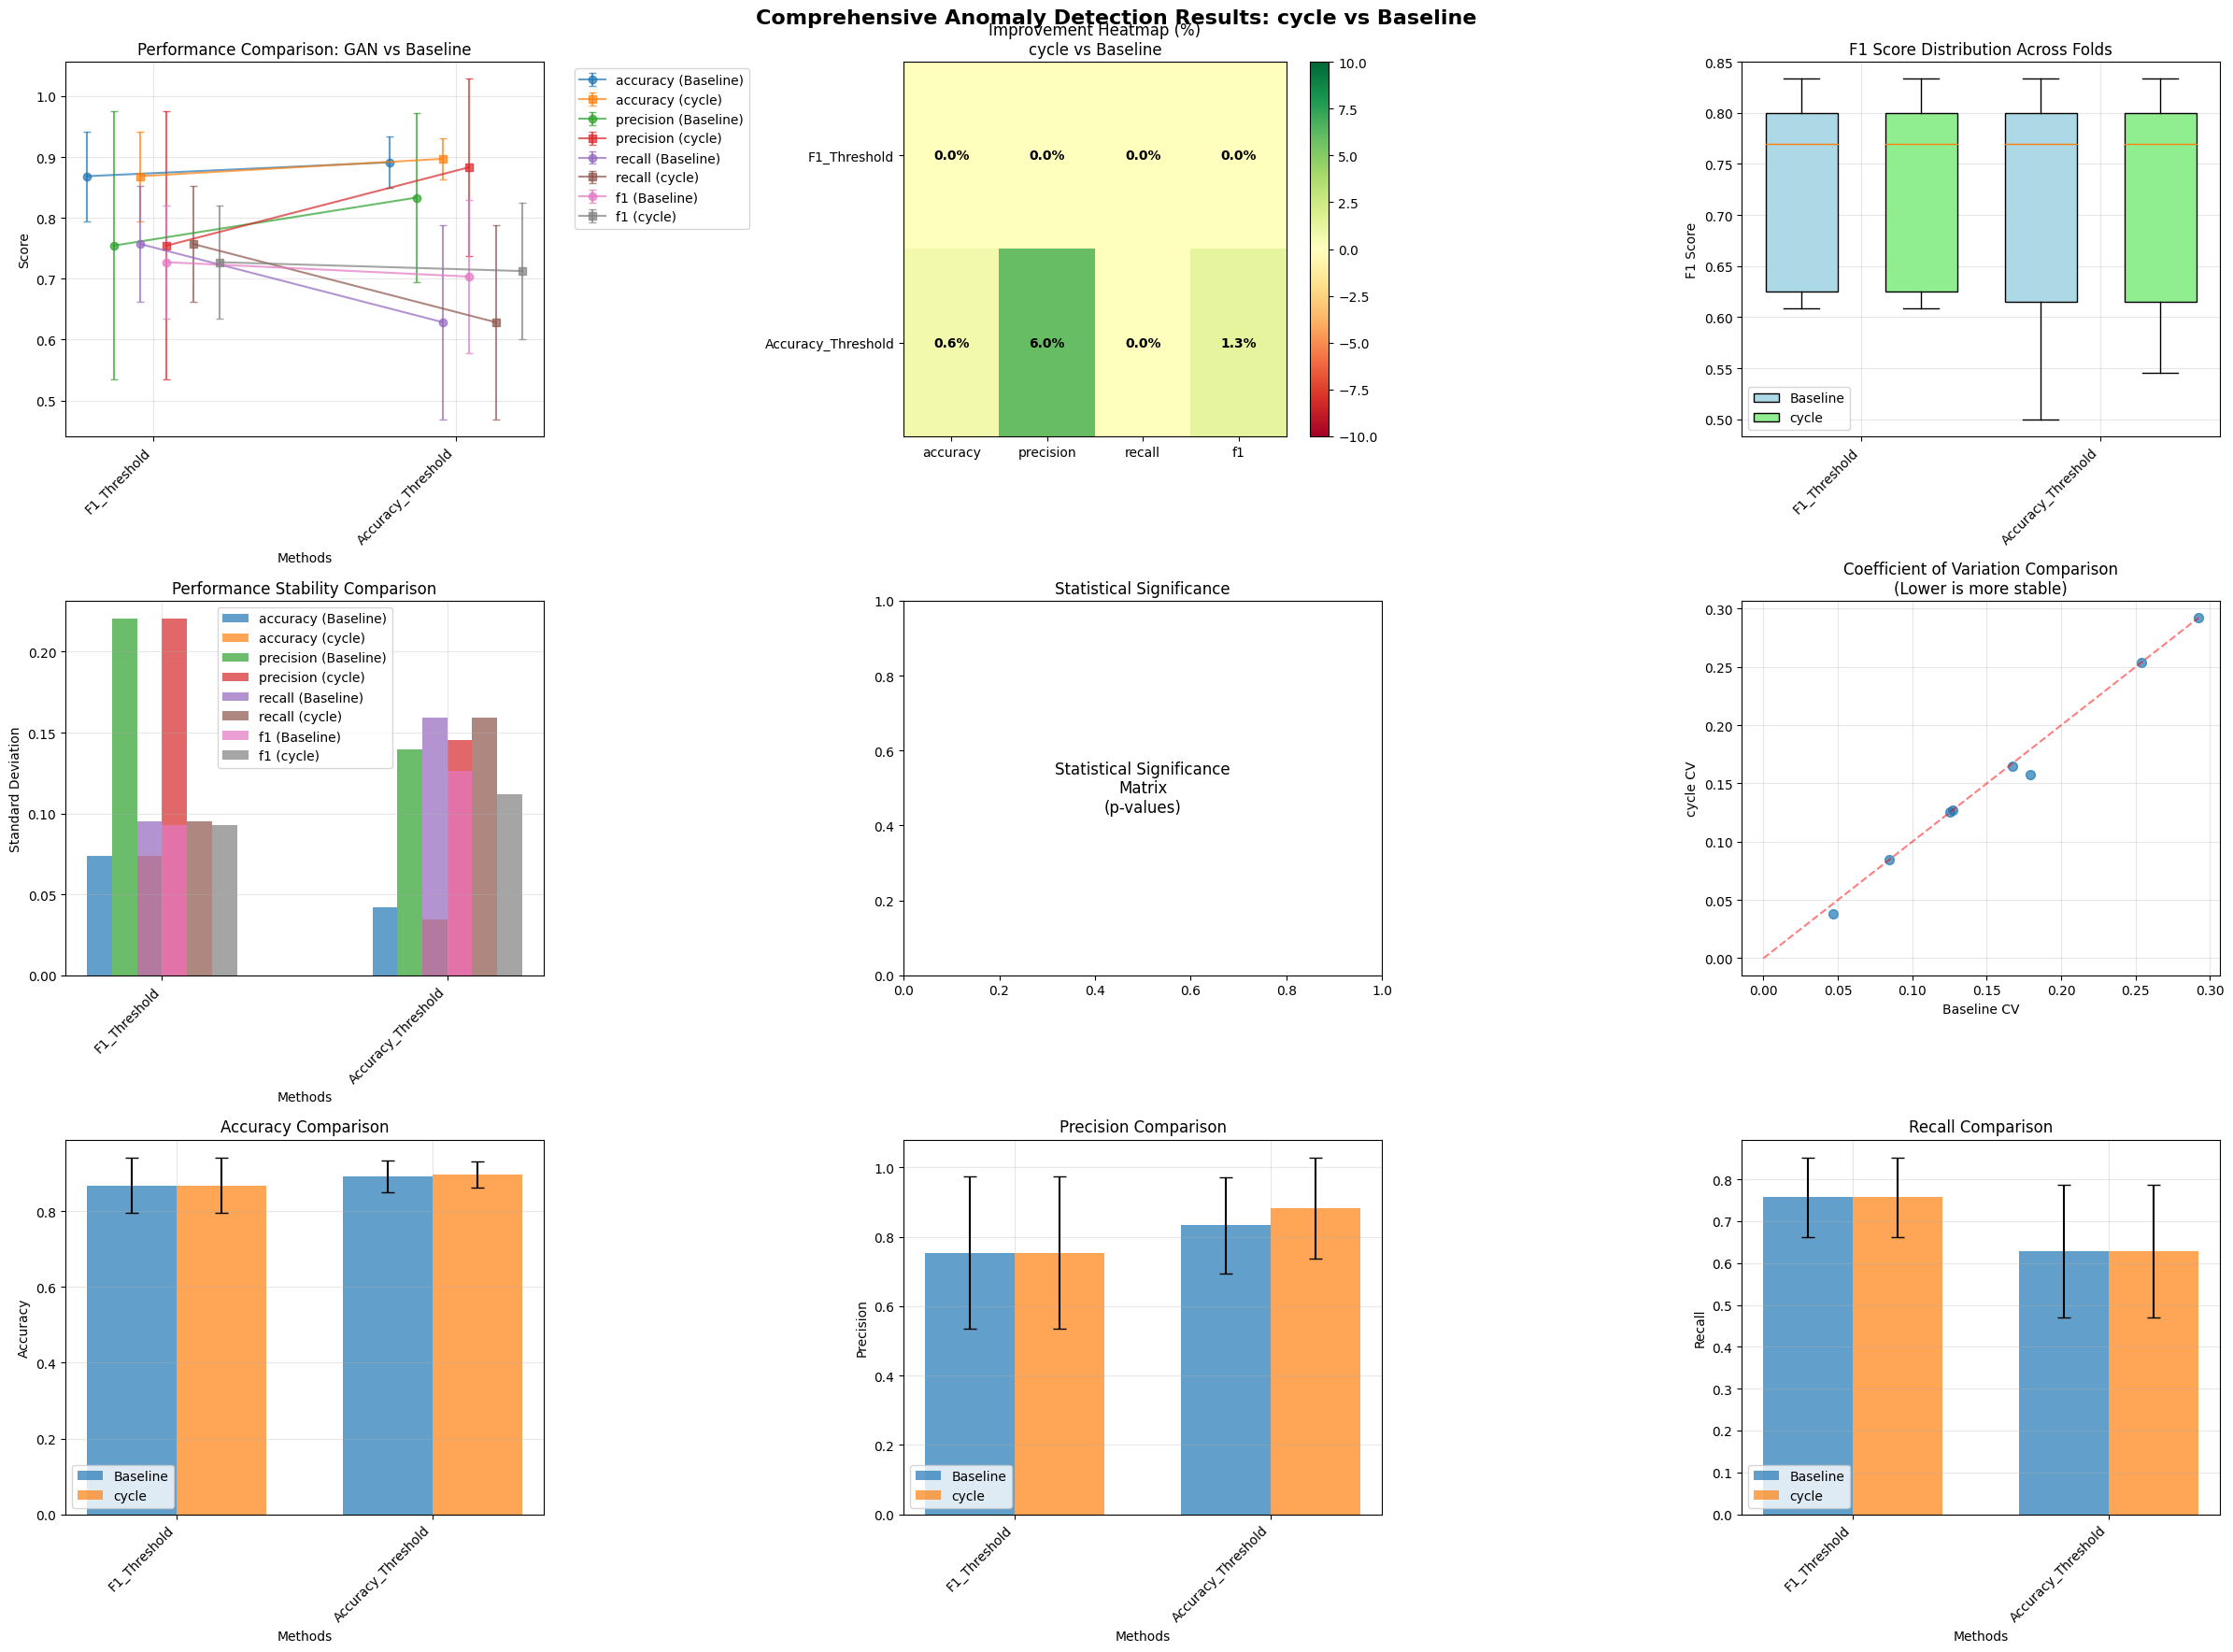


ENHANCED ANOMALY DETECTION RECOMMENDATIONS (cycle)

🏆 BEST METHODS WITH cycle:
   • Best F1 Score: F1_Threshold (0.7273 ± 0.0925)
   • Most Stable: F1_Threshold (CV = 0.1272)

📈 cycle EFFECTIVENESS:
   • F1_Threshold: 0% metrics improved, 0% significantly
   • Accuracy_Threshold: 75% metrics improved, 0% significantly

🎯 cycle OVERALL EFFECTIVENESS: Not Effective
   • 0/8 comparisons show significant improvement
   • Success Rate: 0.0%

📊 METHOD-SPECIFIC INSIGHTS:
   • F1_Threshold          : No Significant Benefit
   • Accuracy_Threshold    : Stability Gain

🎯 FINAL RECOMMENDATIONS:
   ❌ cycle data augmentation shows LIMITED benefit
   • Consider baseline methods or alternative GAN architectures
   • Current success rate: 0.0%

💡 DEPLOYMENT STRATEGY:
   • Stick with baseline methods for now
   • Investigate alternative data augmentation strategies
   • Consider ensemble methods combining multiple approaches



({'F1_Threshold': {'accuracy': {'mean': 0.8685714285714287,
    'std': 0.07362342129557212,
    'min': 0.7428571428571429,
    'max': 0.9428571428571428,
    'median': 0.9142857142857143,
    'values': [0.9142857142857143,
     0.8285714285714286,
     0.9428571428571428,
     0.9142857142857143,
     0.7428571428571429]},
   'precision': {'mean': 0.7544444444444445,
    'std': 0.2204484766656316,
    'min': 0.4666666666666667,
    'max': 1.0,
    'median': 0.75,
    'values': [0.75, 0.5555555555555556, 1.0, 1.0, 0.4666666666666667]},
   'recall': {'mean': 0.7571428571428571,
    'std': 0.09489521611133157,
    'min': 0.625,
    'max': 0.875,
    'median': 0.7142857142857143,
    'values': [0.8571428571428571,
     0.7142857142857143,
     0.7142857142857143,
     0.625,
     0.875]},
   'f1': {'mean': 0.7272519509476031,
    'std': 0.09254060402413204,
    'min': 0.608695652173913,
    'max': 0.8333333333333333,
    'median': 0.7692307692307693,
    'values': [0.7999999999999999,
    

In [5]:
run_comprehensive_cross_validation_experiment(X_test_normal, X_test_faulty, device, synthetic_data, batch_size=32, gan_type="cycle")